In [1]:
# importing required libraries 
import pandas as pd

# for pytorch imports
import torch

# for functional dependencies like activation function 
import torch.nn.functional as F

# nn is basic module in Torch which provide different neural network architecture
import torch.nn as nn

# for optimizer
import torch.optim as optim

# for padding .. since the LSTM takes input as sequence so it is said that 
#if we have fixed input string computation will be faster and it will improve performance 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

from matplotlib import pyplot as plt

In [2]:
# ハイパーパラメータ
NUM_CLASSES = 10
BATCH_SIZE = 128
N_EPOCH = 10

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_dataset = datasets.MNIST('../data', train = True, download = True, transform = transform)
test_dataset = datasets.MNIST('../data', train = False, transform = transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [21]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3), stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1)
        self.maxPool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.drop1 = nn.Dropout(p=0.25)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(12 * 12 * 64, 128)
        self.drop2 = nn.Dropout(p=0.5)
        self.classifier = nn.Linear(128, num_classes)
        self.relu = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.maxPool(x)
        x = self.drop1(x)
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.drop2(x)
        x = self.classifier(x)
        return x

model = Net(NUM_CLASSES)
model = model.to(device)
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxPool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=9216, out_features=128, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=128, out_features=10, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

In [22]:
# モデルの訓練と評価
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = [0] * N_EPOCH
test_losses = [0] * N_EPOCH
for epoch in range(N_EPOCH):
    model.train()
    train_total = 0
    train_loss = 0
    for data, labels in train_dataloader:
        data, labels = data.to(device), labels.to(device)

        # パラメータの勾配をリセット
        optimizer.zero_grad()
        predictions = model(data)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        
        train_total += 1
        train_loss += loss.item()

    model.eval()
    test_total = 0
    test_loss = 0
    with torch.no_grad():
        for data, labels in test_dataloader:
            data, labels = data.to(device), labels.to(device)
            predictions = model(data)
            loss = criterion(predictions, labels)

            test_total += 1
            test_loss += loss.item()

    # LossとAccuracyを表示
    train_losses[epoch] = train_loss / train_total
    test_losses[epoch] = test_loss / test_total
    print(f'Epoch: {epoch+1}, Train Loss: {train_losses[epoch]:.3f}, Test Loss: {test_losses[epoch]:.3f}')

Epoch: 1, Train Loss: 0.260, Test Loss: 0.050
Epoch: 2, Train Loss: 0.079, Test Loss: 0.035
Epoch: 3, Train Loss: 0.059, Test Loss: 0.030
Epoch: 4, Train Loss: 0.049, Test Loss: 0.029
Epoch: 5, Train Loss: 0.039, Test Loss: 0.031
Epoch: 6, Train Loss: 0.036, Test Loss: 0.029
Epoch: 7, Train Loss: 0.031, Test Loss: 0.029
Epoch: 8, Train Loss: 0.027, Test Loss: 0.027
Epoch: 9, Train Loss: 0.025, Test Loss: 0.027
Epoch: 10, Train Loss: 0.024, Test Loss: 0.023


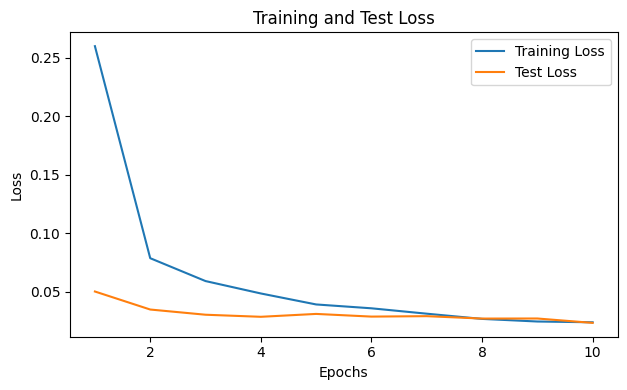

In [23]:
def plot_learning_curves(train_losses, test_losses):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(train_losses, test_losses)

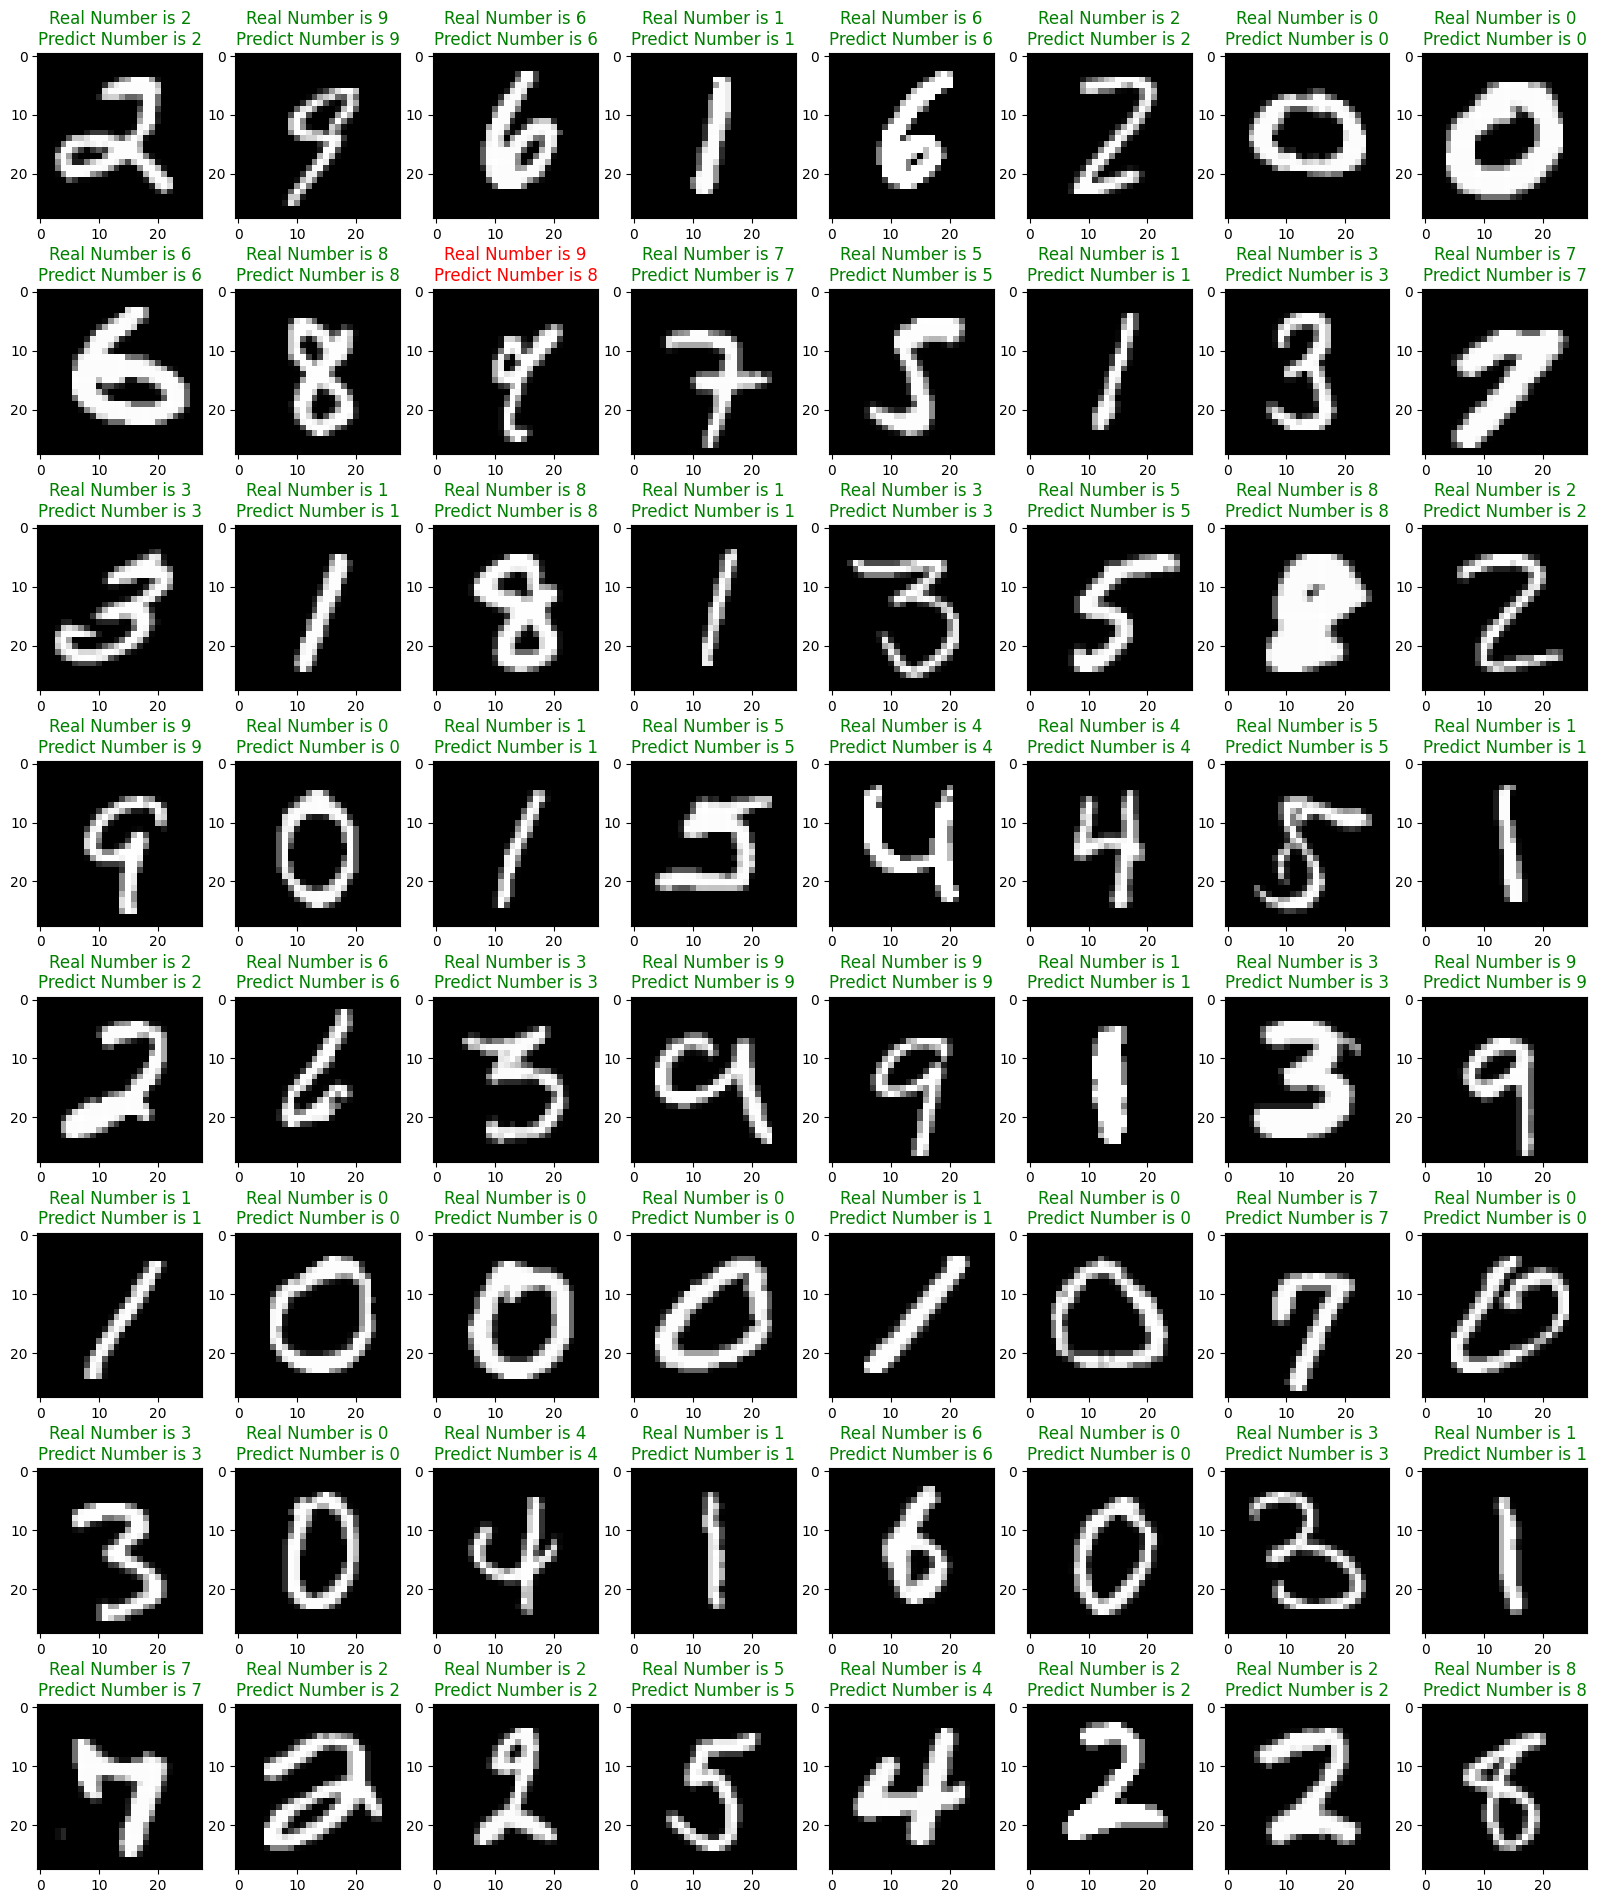

In [24]:
model.eval()
data, labels = next(iter(test_dataloader))
data = data.to(device)
labels = labels.to(device)
pred = model(data)

fig, axis = plt.subplots(8, 8, figsize=(20, 24))
for i, ax in enumerate(axis.flat):
    expected = labels[i]
    actual = pred[i].argmax()
    ax.imshow(data[i].to('cpu').detach().numpy().reshape((28, 28)), cmap='gray')
    ax.set_title(f"Real Number is {expected}\nPredict Number is {actual}", color=("green" if expected == actual else "red"))